In [8]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular
import graphviz

In [28]:
# Read in data into dataframes 
train_features = pd.read_csv(r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\training_features_with_score_GHGEmIn.csv')
test_features = pd.read_csv(r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\testing_features_with_score_GHGEmIn.csv')
train_labels = pd.read_csv(r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\training_labels_with_score_GHGEmIn.csv')
test_labels = pd.read_csv(r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\testing_labels_with_score_GHGEmIn.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (4687, 8)
Testing Feature Size:   (2010, 8)
Training Labels Size:   (4687, 1)
Testing Labels Size:    (2010, 1)


In [29]:
""""
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)
"""
#Recreate Final Model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)
X_train=imputer.fit_transform(train_features)
X_test = imputer.transform(test_features)
X_train

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [30]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [31]:
model = GradientBoostingRegressor(loss='huber', max_depth=15, max_features='sqrt',
                                  min_samples_leaf=2, min_samples_split=6, 
                                  n_estimators=700, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=15,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 58.3402


In [33]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,PropertyGFATotal,0.392234
1,Latitude,0.112881
2,NumberofFloors,0.112678
3,YearBuilt,0.107347
4,ENERGYSTARScore,0.094859
5,Longitude,0.091563
6,PropertyGFAParking,0.080044
7,NumberofBuildings,0.008395


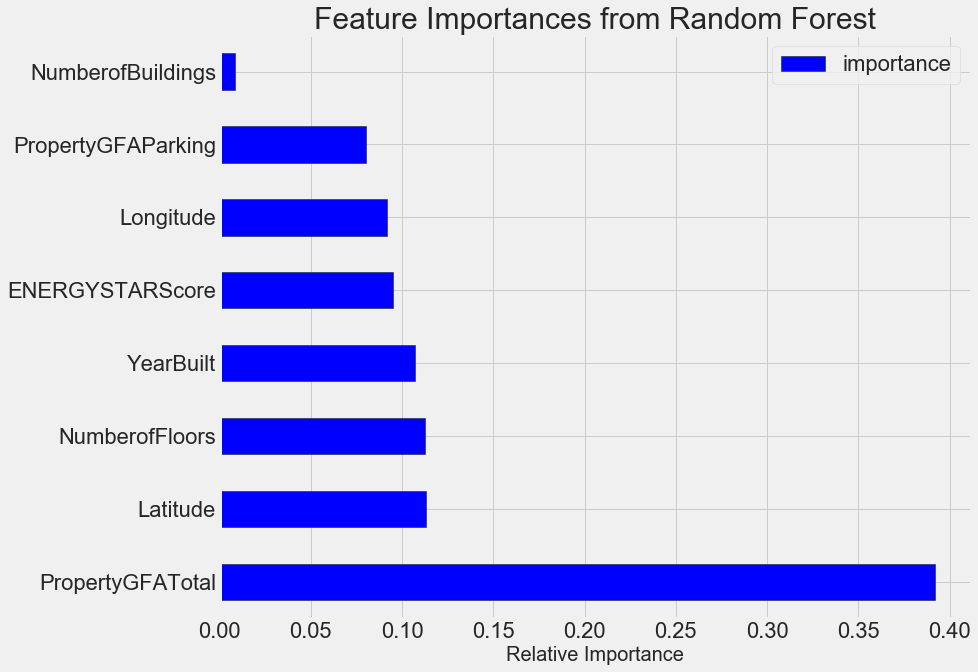

In [34]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

In [35]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (4687, 8)
Most important testing  features shape:  (2010, 8)


In [36]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    107.6039.
Linear Regression Reduced Results: MAE = 107.6039.


In [37]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='huber', max_depth=15, max_features='sqrt',
                                  min_samples_leaf=2, min_samples_split=6, 
                                  n_estimators=700, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 57.1558


In [38]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [39]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 3285.2267
Actual Value: 11824.8900


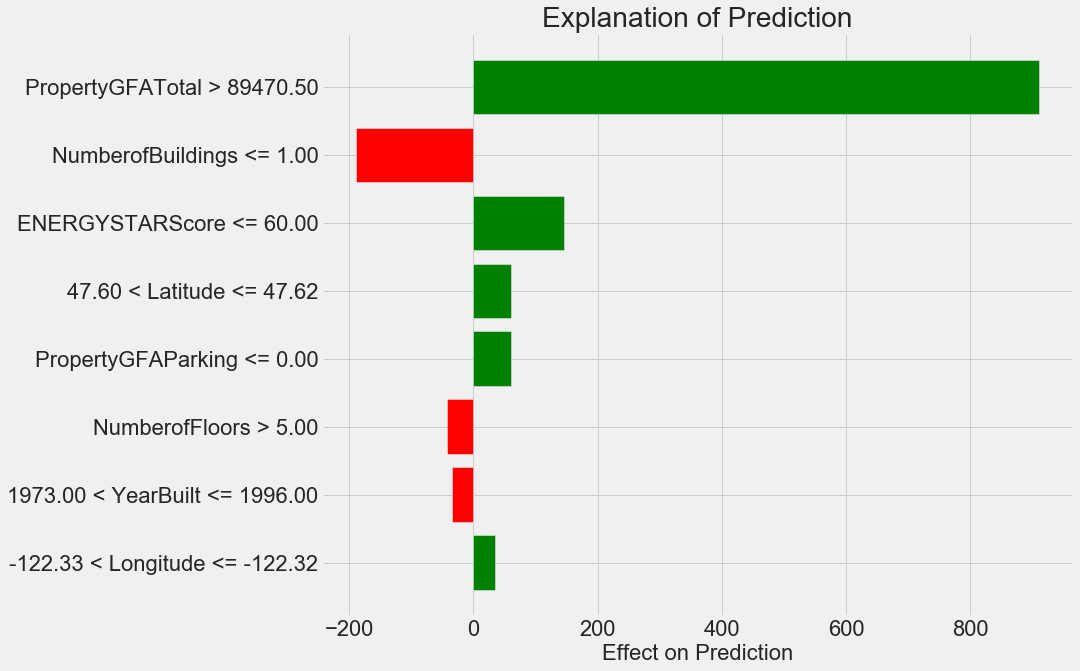

In [40]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [41]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 5.3514
Actual Value: 5.3500


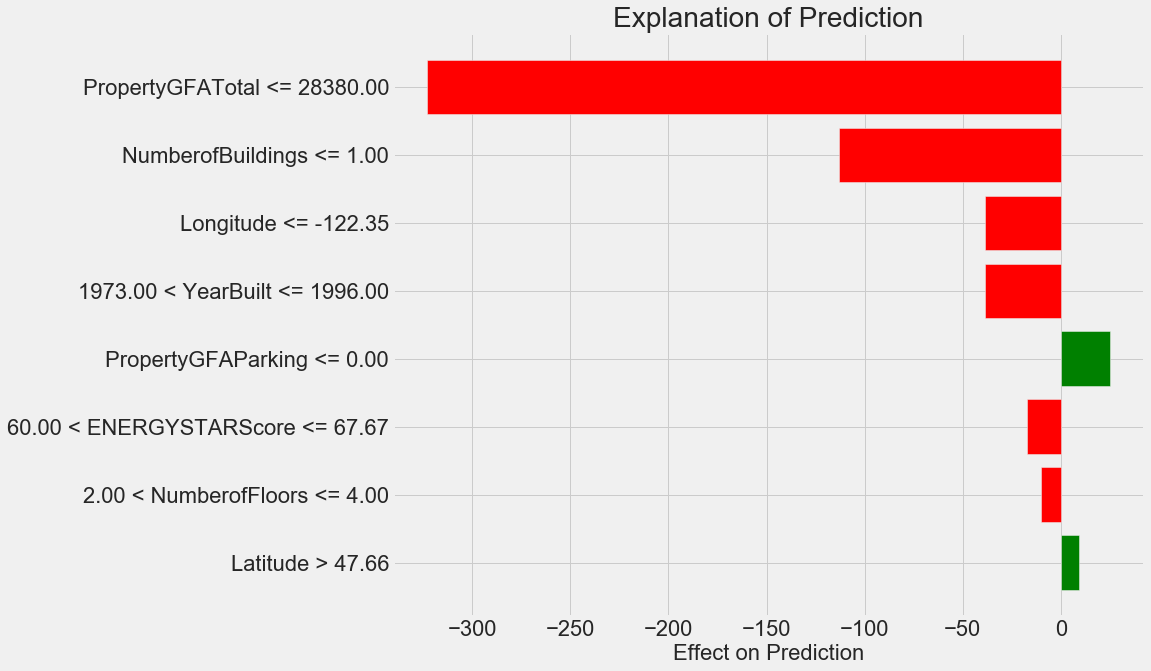

In [42]:
# Display the predicted and true value for the right instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [43]:
right_exp.show_in_notebook(show_predicted_value=False)

In [44]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\images\tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='auto',
                      random_state=RandomState(MT19937) at 0x17CEF414570,
                      splitter='best')

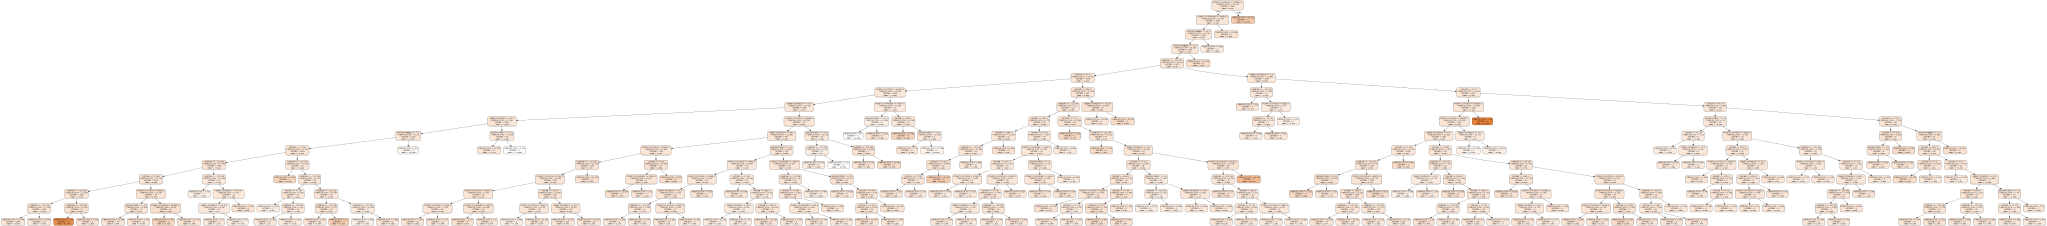

In [45]:
with open(r'C:/Users/mehdi/OneDrive/Documents/OpenClassRooms/Projet 3/images/tree.dot') as tree_image:
    tree_graph = tree_image.read()
graphviz.Source(tree_graph)

In [46]:
tree.export_graphviz(single_tree, out_file = r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\images\tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

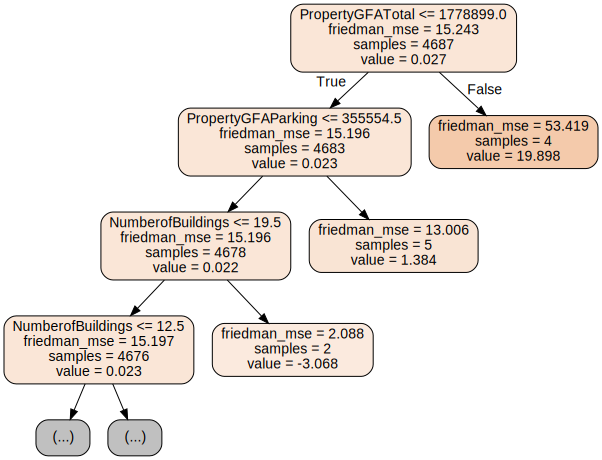

In [47]:
with open(r'C:\Users\mehdi\OneDrive\Documents\OpenClassRooms\Projet 3\images\tree_small.dot') as tree_small_image:
    tree_small_graph = tree_small_image.read()
graphviz.Source(tree_small_graph)